# Proyecto de Aprendizaje Profundo: Clasificación de Cantos de Aves
**Autor**: Daniel López Gala - UO281798

## Contexto del Proyecto
Este proyecto se centra en el análisis y la clasificación de cantos de aves utilizando técnicas de aprendizaje profundo. Se trabaja con el conjunto de datos NIPS4BPLUS, una recopilación especializada de grabaciones de audio que presenta una rica variedad de vocalizaciones de aves.

## Detalles del Conjunto de Datos NIPS4BPLUS
- **Número de Archivos de Audio**: El conjunto de datos consta de 674 archivos de audio.
- **Duración Total**: Los audios suman menos de una hora en total, con grabaciones individuales de aproximadamente 5 segundos cada una.
- **Diversidad de Ubicaciones**: Las grabaciones se realizaron en 39 ubicaciones distintas, abarcando 7 regiones geográficas entre Francia y España. Esta diversidad de locaciones aporta una amplia gama de contextos acústicos y fondos ambientales.
- **Contenido del Audio**: Cada archivo de audio contiene cantos y llamadas de diversas especies de aves, lo que representa un desafío interesante y realista para los modelos de clasificación de aprendizaje profundo.

## Objetivo del Proyecto
El objetivo es desarrollar y entrenar un modelo de red neuronal profunda capaz de identificar y clasificar los diferentes cantos de aves que aparecen en estos audios. Este trabajo, desarrollado en el campo del procesamiento de señales de audio y aprendizaje profundo, tiene aplicaciones prácticas en áreas como la bioacústica, la conservación de la biodiversidad y el estudio del comportamiento animal.

In [1]:
GOOGLE_COLAB = False
DEBUG = True

In [2]:
if GOOGLE_COLAB:
    base_path = "/content/drive/MyDrive/DeepLearning/"
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install scikit-multilearn
    !pip install wandb
else:
    base_path = ""

In [3]:
import os
import random
from collections import defaultdict
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import cv2

import torchaudio
import torchaudio.transforms as T

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.models as models

from sklearn.metrics import f1_score

import wandb
from skmultilearn.model_selection import iterative_train_test_split

## Preprocesamiento y visualización

- Se define una función `visualize_intermediates` para crear imágenes de los pasos intermedios usados en el preprocesamiento de los audios.

- Se ha implementado una serie de pasos detallados para procesar y transformar las señales de audio en una forma más adecuada para el análisis de redes neuronales. Los pasos incluidos son:

1. **Reescalamiento de Frecuencia (Resampling)**: Aunque inicialmente no se utiliza, se ha preparado un mecanismo para cambiar la frecuencia de muestreo de las señales de audio si fuera necesario.

2. **Transformada de Fourier de Tiempo Corto (STFT) a Espectrograma de Mel**: Se convierten las señales de audio a espectrogramas de Mel, enfocándose en un rango de frecuencia de 500 a 15000 Hz, que es donde típicamente se encuentran los sonidos de aves.

3. **Normalización**: Los espectrogramas son normalizados para tener valores en un rango uniforme, lo cual es crucial para el entrenamiento efectivo de modelos de aprendizaje profundo.

4. **Desenfoque Mediano (Median Blurring)**: Se aplica un desenfoque mediano para suavizar el espectrograma, reduciendo así el ruido y mejorando la visibilidad de las características relevantes.

5. **Creación de Imágenes Binarias**: Se implementa un método para crear imágenes binarias a partir de los espectrogramas, utilizando un umbral adaptativo basado en percentiles tanto para bandas de frecuencia como para marcos temporales.

6. **Transformaciones de Data Augmentation (solo si augment=True)**:
   - Desplazamiento Temporal Aleatorio: Se aplica un desplazamiento aleatorio en el dominio del tiempo a la señal de audio.
   - Cambio de Tono Aleatorio: Se realiza un cambio aleatorio en el tono de la señal de audio.
   - Ganancia de Volumen Aleatoria: Se ajusta el volumen de la señal de audio de manera aleatoria.

Debugging: Si debug está activado, se almacenan los espectrogramas intermedios para su visualización y análisis posterior.

In [4]:
def visualize_intermediates(intermediates, sample_rate=44100, hop_length=196):

    # Set default background color for figures to white
    plt.rcParams['figure.facecolor'] = 'white'

    for key, value in intermediates.items():
        if len(value.shape) == 2 and value.shape[1] > 2:  # This indicates a waveform
            plt.figure(figsize=(12, 4))

            # Calculate time axis in seconds for waveform
            time_axis_waveform = np.linspace(0, value.shape[1] / sample_rate, value.shape[1])

            plt.plot(time_axis_waveform, value[0].cpu().numpy())
            plt.xlabel("Time (seconds)")
            plt.title(f"{key}")
            plt.show()
            continue

        print(f"Processing {key} with shape {value.shape}")

        if value.dim() == 4 and value.shape[-1] == 2:
            complex_representation = value[0, ..., 0] + 1j * value[0, ..., 1]  # Convert to complex
            magnitude = torch.abs(complex_representation).cpu().numpy()
            phase = torch.angle(complex_representation).cpu().numpy()
        elif value.is_complex():
            magnitude = torch.abs(value).squeeze().cpu().numpy()
            phase = torch.angle(value).squeeze().cpu().numpy()
        else:
            magnitude = value.squeeze().cpu().numpy()
            phase = None

        # Calculate time axis in seconds for magnitude
        time_axis_magnitude = np.linspace(0, magnitude.shape[1] * hop_length / sample_rate, magnitude.shape[1])

        # Plot magnitude with inverted grayscale colormap
        plt.figure(figsize=(12, 4))
        plt.imshow(magnitude, cmap='gray_r', aspect='auto', origin='lower', extent=[time_axis_magnitude[0], time_axis_magnitude[-1], 0, magnitude.shape[0]])
        plt.xlabel("Time (seconds)")
        plt.title(f"{key} Magnitude")
        plt.colorbar()
        plt.show()

        # Plot phase
        if phase is not None:
            plt.figure(figsize=(12, 4))
            plt.imshow(((phase + np.pi) % (2 * np.pi) - np.pi), cmap='hsv', aspect='auto', origin='lower', vmin=-np.pi, vmax=np.pi, extent=[time_axis_magnitude[0], time_axis_magnitude[-1], 0, phase.shape[0]])
            plt.xlabel("Time (seconds)")
            plt.title(f"{key} Phase")
            plt.colorbar()
            plt.show()


In [5]:
class AudioPreprocessing(nn.Module):
    def __init__(
        self,
        debug=DEBUG,
        sample_rate=44100,
        n_fft=1024,
        win_length=1024,
        hop_length=196,
        augment=False,
    ):
        super().__init__()
        self.debug = debug
        self.augment = augment
        self.sample_rate = sample_rate
        self.resampler = T.Resample(44100, sample_rate)
        self.spectrogram = T.MelSpectrogram(
            sample_rate,
            n_fft=n_fft,
            win_length=win_length,
            hop_length=hop_length,
            f_min=500,
            f_max=15000,
        )

    def normalize(self, spectrogram):
        min_val = torch.min(spectrogram)
        return (spectrogram - min_val) / (torch.max(spectrogram) - min_val + 1e-5)

    def median_blurring(self, spectrogram):
        img = spectrogram.squeeze(0).cpu().numpy()
        img = cv2.medianBlur(img.astype(np.float32), 5)
        return torch.tensor(img, device=spectrogram.device).float().unsqueeze(0)

    def binary_image_creation(self, spectrogram, percentile=75):
        # Calculate the percentile value instead of median for each frequency band
        freq_thresholds = torch.quantile(
            spectrogram, percentile / 100.0, dim=2, keepdim=True
        )
        # Calculate the percentile value for each time frame
        time_thresholds = torch.quantile(
            spectrogram, percentile / 100.0, dim=1, keepdim=True
        )

        # Create a mask based on the adaptive thresholding
        mask = (spectrogram > freq_thresholds) & (spectrogram > time_thresholds)
        return mask.float()

    # def spot_removal(self, spectrogram, threshold=0.5):
    #     # Threshold the spectrogram to get a binary mask
    #     binary_mask = (spectrogram > threshold).float()

    #     # Convert to numpy for morphological operations
    #     binary_np = binary_mask.squeeze(0).cpu().numpy().astype(np.uint8)

    #     # Define a kernel for morphological operations (adjust size as needed)
    #     kernel = np.ones((3, 3), np.uint8)

    #     # Perform morphological opening to remove small noise
    #     cleaned_binary_np = cv2.morphologyEx(binary_np, cv2.MORPH_OPEN, kernel)

    #     # Convert back to tensor
    #     cleaned_binary_mask = torch.tensor(cleaned_binary_np, device=spectrogram.device).float().unsqueeze(0)

    #     # Multiply with original spectrogram to remove the noise
    #     denoised_spectrogram = spectrogram * cleaned_binary_mask

    #     return denoised_spectrogram

    # def morph_closing(self, spectrogram):
    #     img = spectrogram.squeeze(0).cpu().numpy()
    #     kernel = np.ones((3, 3), np.uint8)
    #     img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    #     return torch.tensor(img, device=spectrogram.device).float().unsqueeze(0)

    def random_time_shift(self, waveform, max_shift_sec=0.2):
        """Randomly shifts the waveform in the time domain"""
        max_shift = int(max_shift_sec * self.sample_rate)
        shift = random.randint(-max_shift, max_shift)
        return torch.roll(waveform, shifts=shift, dims=-1)

    def random_pitch_shift(self, waveform, max_shift=2):
        """Randomly shifts the pitch of the waveform"""
        shift = random.uniform(-max_shift, max_shift)
        return T.FrequencyMasking(freq_mask_param=int(shift))(waveform)

    def random_volume_gain(self, waveform, min_gain=0.5, max_gain=1.5):
        """Randomly changes the volume of the waveform"""
        gain = random.uniform(min_gain, max_gain)
        return waveform * gain

    def forward(self, waveform):
        intermediates = {}

        # Data augmentation
        if self.augment:
            waveform = self.random_time_shift(waveform)
            waveform = self.random_pitch_shift(waveform)
            waveform = self.random_volume_gain(waveform)

        spectrogram = self.spectrogram(waveform)
        if self.debug:
            intermediates["original_spectrograms"] = spectrogram

        spectrogram = self.normalize(spectrogram)
        spectrogram = self.median_blurring(spectrogram)
        if self.debug:
            intermediates["spectrograms_after_median_blurring"] = spectrogram

        spectrogram = self.binary_image_creation(spectrogram)
        if self.debug:
            intermediates["binary_image"] = spectrogram

        # spectrogram = self.morph_closing(spectrogram)
        # if self.debug: intermediates['spectrograms_after_morph_closing'] = spectrogram

        # spectrogram = self.spot_removal(spectrogram)
        # if self.debug: intermediates['spectrograms_after_spot_removal'] = spectrogram

        if not self.debug:
            return spectrogram, {}

        return (spectrogram, intermediates)

## Carga y Preprocesamiento de Datos de Audios de Aves

En esta sección, se procesan y preparan los audios para su uso en el entrenamiento y validación de modelos de clasificación de cantos de aves. El enfoque es **multietiqueta**, considerando que cada audio puede contener los sonidos de múltiples especies de aves.


### Dataset y Transformaciones

La clase `BirdSongDataset` se encarga de la carga y el preprocesamiento de los audios:

1. **Inicialización (__init__)**: Recibe un DataFrame con información de los segmentos de audio, un directorio donde se encuentran los audios, información de las clases y una transformación opcional.
   - Los audios se dividen en segmentos de 1 segundo. Cada segmento se etiqueta con las clases de aves presentes en ese intervalo de tiempo.
   - Se crea una lista de segmentos, donde cada segmento contiene información como el nombre del archivo, índice del segmento, tiempos de inicio y fin, y las clases correspondientes.
   
2. **Obtención de Elementos (__getitem__)**: Retorna un segmento de audio y su etiqueta objetivo.
   - Carga y extrae el segmento de audio especificado, aplicando padding si es necesario para alcanzar una duración de 1 segundo.
   - Convierte las etiquetas de clase en un vector binario que representa la presencia o ausencia de cada clase en el segmento.

### Creación de Conjuntos de Datos y Transformaciones
El código posterior crea conjuntos de datos de entrenamiento y validación:
   - Se cargan los datos de entrenamiento y la información de las clases desde archivos CSV.
   - Se transforman las etiquetas a una forma binaria, adecuada para la clasificación multietiqueta.
   - Se emplea `iterative_train_test_split` para dividir los datos, manteniendo la proporción de clases en los conjuntos de entrenamiento y validación.
   - Se definen transformaciones específicas para cada conjunto. Para entrenamiento, se incluyen aumentos de datos (`augment=True`), mientras que para validación no se aplican aumentos (`augment=False`).
   - Finalmente, se instancian los objetos `BirdSongDataset` para ambos conjuntos, aplicando las transformaciones definidas.

In [6]:
class BirdSongDataset(Dataset):
    def __init__(self, df, audio_dir, class_info, transform=None):
        segments = []

        unique_filenames = df["filename"].unique()  # Only process each audio file once
        for unique_filename in unique_filenames:
            audio_path = os.path.join(audio_dir, unique_filename)
            waveform, sample_rate = torchaudio.load(audio_path)
            total_segments = int(
                math.ceil(waveform.shape[1] / sample_rate)
            )  # Total segments in the audio

            # Calculate the unique labels for each segment
            for idx in range(total_segments):
                start_time, end_time = idx, idx + 1
                labels_in_segment = (
                    df[
                        (df["filename"] == unique_filename)
                        & (df["end"] > start_time)
                        & (df["start"] < end_time)
                    ]["class"]
                    .unique()
                    .tolist()
                )
                segments.append(
                    {
                        "filename": unique_filename,
                        "segment_idx": idx,
                        "start": start_time,
                        "end": end_time,
                        "class": ",".join(labels_in_segment),
                    }
                )

        self.segments = pd.DataFrame(segments)
        self.audio_dir = audio_dir
        self.class_info = class_info
        self.transform = transform

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        row = self.segments.iloc[idx]
        audio_path = os.path.join(self.audio_dir, row["filename"])
        waveform, sample_rate = torchaudio.load(audio_path)

        # Extract 1-second segment
        start_sample = int(row["start"] * sample_rate)
        end_sample = int(row["end"] * sample_rate)
        waveform = waveform[:, start_sample:end_sample]

        # Padding if needed
        if waveform.shape[1] < sample_rate:
            num_padding = sample_rate - waveform.shape[1]
            waveform = torch.cat([waveform, torch.zeros(1, num_padding)], dim=1)

        class_names = row["class"].split(",") if row["class"] else []
        target = torch.zeros(len(self.class_info))
        for class_name in class_names:
            target[self.class_info.index(class_name)] = 1.0

        if self.transform:
            waveform = self.transform(waveform)

        return waveform, target

    def get_filename(self, idx):
        return self.segments.iloc[idx]["filename"]


train_csv = pd.read_csv(
    f"{base_path}data/train.csv"
)  # CSV with train audio filenames, and bird class names labels.
class_info_csv = pd.read_csv(f"{base_path}data/class_info.csv")
class_names = class_info_csv["class name"].tolist()

# Convert the labels to a binary matrix form
y = np.zeros((len(train_csv), len(class_names)))
for i, (_, row) in enumerate(train_csv.iterrows()):
    labels = row["class"].split(",")
    for label in labels:
        y[i, class_names.index(label)] = 1

X_train, y_train, X_val, y_val = iterative_train_test_split(
    np.array(train_csv), y, test_size=0.1
)

train_df = pd.DataFrame(X_train, columns=train_csv.columns)
valid_df = pd.DataFrame(X_val, columns=train_csv.columns)

train_transform = nn.Sequential(AudioPreprocessing(augment=True))

valid_transform = nn.Sequential(AudioPreprocessing(augment=False))

train_dataset = BirdSongDataset(
    train_df, f"{base_path}data/train/", class_names, transform=train_transform
)
valid_dataset = BirdSongDataset(
    valid_df, f"{base_path}data/train/", class_names, transform=valid_transform
)

## Agregación de Predicciones y Visualización de Segmentos Específicos

### Función de Agregación de Predicciones
La función `aggregate_predictions` se utiliza para combinar las predicciones hechas sobre segmentos individuales de audio en predicciones por archivo de audio. Esto es útil para interpretar los resultados del modelo.

- **Entradas**: Recibe `predictions`, una lista de conjuntos con las predicciones de clases para cada segmento, y `segments_df`, un DataFrame que contiene información de los segmentos.
- **Proceso**: Para cada archivo de audio único en `segments_df`, agrega las predicciones de todos los segmentos correspondientes a ese archivo.
- **Salida**: Devuelve un diccionario donde cada clave es un nombre de archivo de audio y cada valor es un conjunto de clases predichas en ese audio.

In [7]:
def aggregate_predictions(predictions, segments_df):
    aggregated_predictions = {}
    for filename in segments_df["filename"].unique():
        aggregated_predictions[filename] = set()
        segments = segments_df[segments_df["filename"] == filename]
        for idx, row in segments.iterrows():
            aggregated_predictions[filename].update(predictions[idx])
    return aggregated_predictions

### Visualización de Segmentos Específicos
El código adicional ilustra cómo seleccionar y visualizar información de segmentos específicos de un archivo de audio en el dataset.

- Se filtra train_dataset.segments para obtener los segmentos correspondientes a un archivo de audio específico, en este caso 'nips4b_train001.wav'.
- Se selecciona un segmento específico usando su índice, obteniendo su forma de onda y etiqueta.
- Se imprime la etiqueta del segmento seleccionado y se convierte la etiqueta tensorial a nombres de clases para facilitar la interpretación.

In [8]:
specific_audio_segments = train_dataset.segments[
    train_dataset.segments["filename"] == "nips4b_train001.wav"
]
print(specific_audio_segments)

              filename  segment_idx  start  end                    class
0  nips4b_train001.wav            0      0    1              Sylcan_song
1  nips4b_train001.wav            1      1    2  Sylcan_song,Petpet_song
2  nips4b_train001.wav            2      2    3  Petpet_song,Sylcan_song
3  nips4b_train001.wav            3      3    4              Petpet_song
4  nips4b_train001.wav            4      4    5                         
5  nips4b_train001.wav            5      5    6                         


In [9]:
segment_idx = 2
waveform, label = train_dataset[segment_idx]
print(f"Label: {label}")

# Convert tensor label back to class names to check
predicted_classes = [
    class_name for idx, class_name in enumerate(class_names) if label[idx] == 1.0
]
print("Predicted Classes:", predicted_classes)

Label: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Predicted Classes: ['Petpet_song', 'Sylcan_song']


### Visualización de Muestras del Dataset

Este fragmento de código está diseñado para ejecutarse en modo `debug` y proporciona información detallada sobre muestras específicas de los conjuntos de datos de validación y entrenamiento.

- **Número de Elementos**: Imprime la cantidad total de elementos en el conjunto de datos de validación (valid_dataset) y entrenamiento (train_dataset).
- **Selección de Muestra y Objetivo**: Selecciona una muestra específica de cada conjunto de datos (índices 90 y 30 respectivamente) y extrae la muestra procesada y las etiquetas objetivo.
- **Detalles de la Muestra**:
  - Imprime la forma del audio procesado.
  - Calcula y muestra el número de etiquetas positivas (clases presentes) en la muestra.
  - Convierte las etiquetas tensoriales a nombres de clases y las imprime, facilitando la interpretación.
- **Visualización de Intermedios**: Llama a `visualize_intermediates` para mostrar representaciones intermedias del procesamiento del audio, si está disponible.

Number of elements: 689
torch.Size([1, 128, 226])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Number of positive labels: 1.0
Predicted Classes: ['Sylmel_call']
Processing original_spectrograms with shape torch.Size([1, 128, 226])


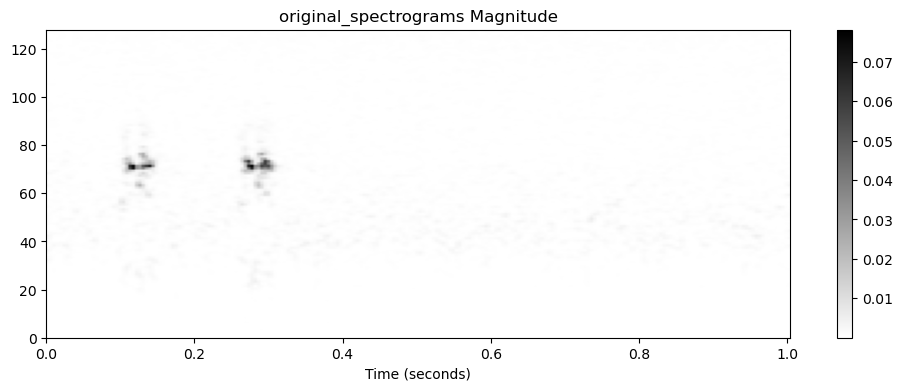

Processing spectrograms_after_median_blurring with shape torch.Size([1, 128, 226])


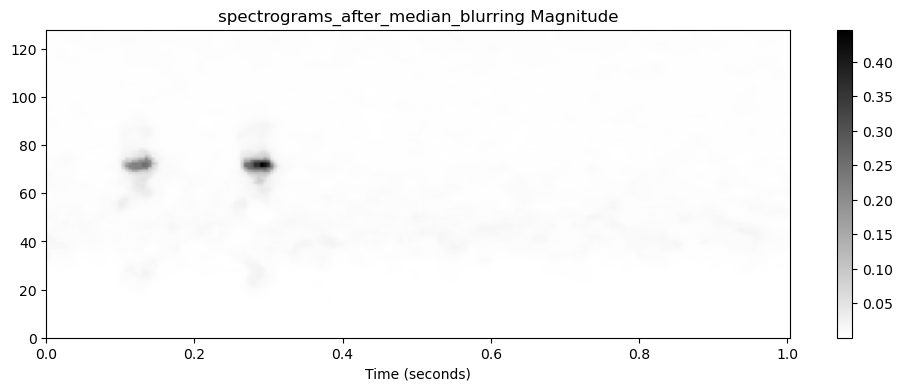

Processing binary_image with shape torch.Size([1, 128, 226])


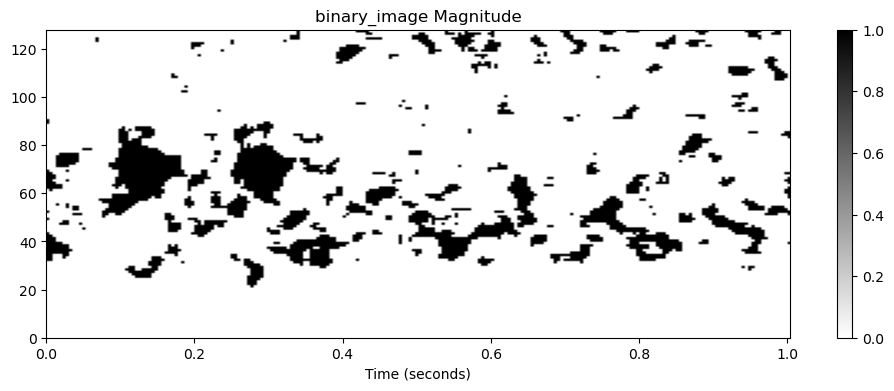

In [10]:
if DEBUG:
    print(f"Number of elements: {len(valid_dataset)}")
    sample, target = valid_dataset[90]
    processed_sample, intermediates = sample

    print(processed_sample.shape)
    num_positive_labels = target.sum().item()
    print(target)
    print(f"Number of positive labels: {num_positive_labels}")

    predicted_classes = [
        class_name for idx, class_name in enumerate(class_names) if target[idx] == 1.0
    ]
    print("Predicted Classes:", predicted_classes)

    visualize_intermediates(intermediates)

Number of elements: 2583
torch.Size([1, 128, 226])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Number of positive labels: 3.0
Predicted Classes: ['Embcir_song', 'Parate_song', 'Siteur_song']
Processing original_spectrograms with shape torch.Size([1, 128, 226])


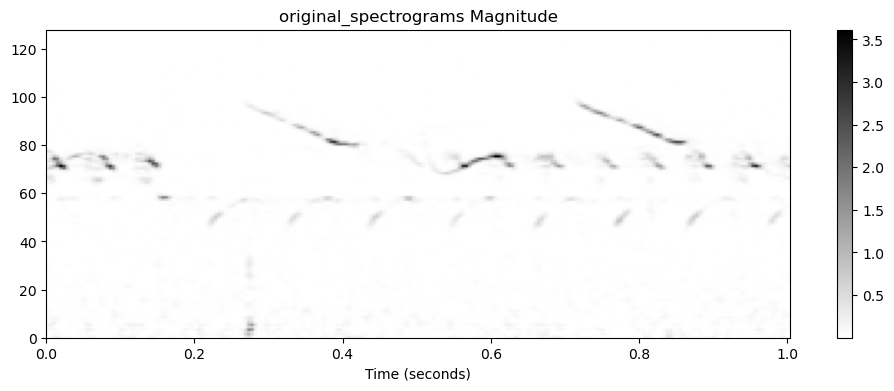

Processing spectrograms_after_median_blurring with shape torch.Size([1, 128, 226])


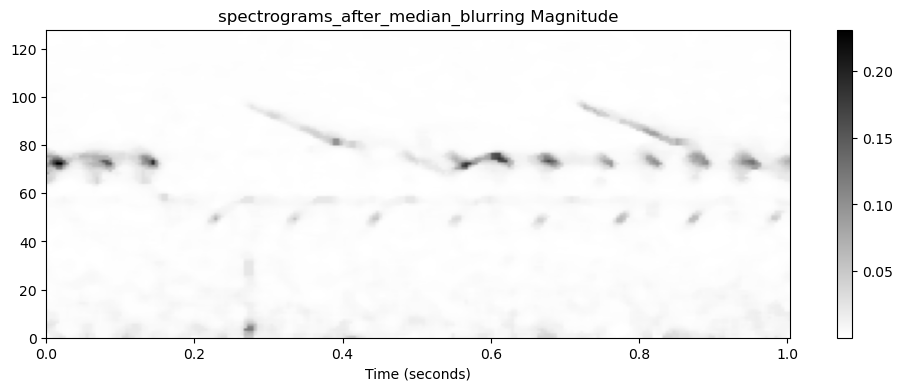

Processing binary_image with shape torch.Size([1, 128, 226])


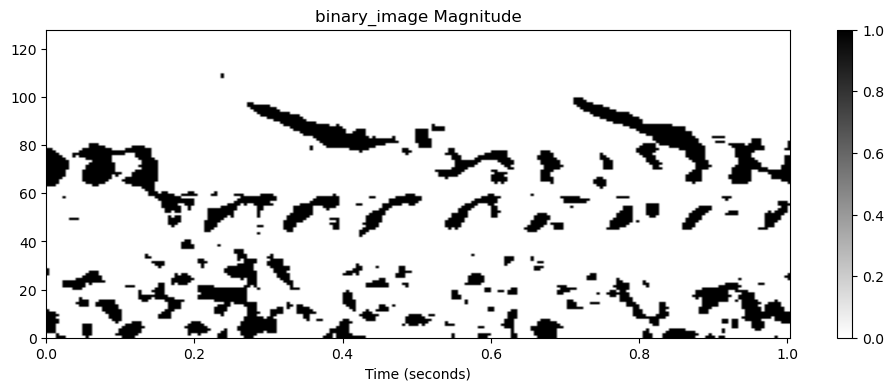

In [11]:
if DEBUG:
    print(f"Number of elements: {len(train_dataset)}")
    sample, target = train_dataset[30]
    processed_sample, intermediates = sample

    print(processed_sample.shape)
    num_positive_labels = target.sum().item()
    print(target)
    print(f"Number of positive labels: {num_positive_labels}")

    predicted_classes = [
        class_name for idx, class_name in enumerate(class_names) if target[idx] == 1.0
    ]
    print("Predicted Classes:", predicted_classes)
    visualize_intermediates(intermediates)

### Calcular la longitud máxima de las formas de onda

La función `collate_fn` se utiliza para procesar y combinar un lote (batch) de muestras en el DataLoader, adaptándose a diferentes escenarios:

1. **Manejo de Diferentes Tipos de Datos en los Lotes**:
   - **Conjunto de Pruebas (Test Set)**: Cuando el objetivo es un nombre de archivo (string), se apila las formas de onda o espectrogramas y se devuelven junto con los nombres de archivo.
   - **Depuración con Diccionario de Intermedios (DEBUG)**: Si el objetivo es un diccionario (usualmente cuando DEBUG es Falso), solo se devuelven las formas de onda o espectrogramas.
   - **Entrenamiento o Validación**: En el caso de lotes de entrenamiento o validación, se apilan las formas de onda o espectrogramas y los objetivos (etiquetas), devolviéndolos para su uso en el modelo.

2. **Uniformidad en la Longitud de las Muestras**:
   - Se extraen las formas de onda o espectrogramas de cada muestra del lote. Si es necesario, se realiza relleno (padding) o truncado para asegurar que todas tengan la misma longitud, facilitando su procesamiento en el modelo.

3. **Creación de DataLoaders para Entrenamiento y Validación**:
   - Se instancian los DataLoaders para los conjuntos de entrenamiento (`train_loader`) y validación (`valid_loader`), especificando el tamaño del lote (`BATCH_SIZE`), el orden de las muestras (aleatorio para entrenamiento, secuencial para validación) y la función `collate_fn` para la preparación de los lotes.

In [12]:
def collate_fn(batch):
    # Extract the waveform (or spectrogram) and ignore intermediates (the dict used to debug) if they exist
    waveforms_or_spectrograms = [
        wf[0] if isinstance(wf, tuple) else wf for wf, _ in batch
    ]

    if isinstance(batch[0][1], str):
        # This handles the Test set scenario where targets might be filenames
        waveforms_or_spectrograms = torch.stack(waveforms_or_spectrograms)
        _, filenames = zip(*batch)
        return waveforms_or_spectrograms, filenames

    elif isinstance(batch[0][1], dict):
        # This handles the scenario where DEBUG is False and intermediates dictionary is returned
        waveforms_or_spectrograms = torch.stack(waveforms_or_spectrograms)
        return waveforms_or_spectrograms  # Note: Here we return only the waveforms as there are no target labels

    else:
        # This handles the Training or validation batch scenario
        waveforms_or_spectrograms = torch.stack(waveforms_or_spectrograms)
        _, targets = zip(*batch)
        targets = torch.stack(targets)
        return waveforms_or_spectrograms, targets


BATCH_SIZE = 64
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn
)
valid_loader = DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn
)

# Definición y Adaptación del Modelo ResNet para Clasificación Multietiqueta
En esta sección, se presenta una arquitectura de red neuronal para la clasificación multietiqueta de audios de aves. Se utiliza una variante personalizada del modelo ResNet, específicamente ResNet101, adaptada para el problema en cuestión.

## Características Principales del Modelo
- **Arquitectura Base:** Se parte de ResNet101 preentrenado, aprovechando las capacidades de extracción de características de esta red profunda y ampliamente probada.
- **Adaptación para Imágenes en Escala de Grises:** La primera capa convolucional se modifica para manejar imágenes de un solo canal (escala de grises), adecuado para los espectrogramas de los audios de aves.
- **Personalización de la Capa de Salida:** La última capa completamente conectada de ResNet se reemplaza por una secuencia personalizada de capas, terminando en una activación sigmoide para adecuarse a la clasificación multietiqueta.

## Detalles de la Capa Personalizada
1. **Dropout**: Se introduce una capa de dropout con un nivel de `0.25` para reducir el sobreajuste.
2. **Capas Lineales y Activaciones**:
   - Una capa lineal reduce la dimensionalidad desde el tamaño de entrada de la última capa de ResNet a 512.
   - Se aplica una función de activación ReLU seguida de otra capa de dropout.
   - Finalmente, una capa lineal transforma la representación a la dimensión del número de clases, y una activación sigmoide genera las probabilidades de las etiquetas multietiqueta.

## Estrategia de Entrenamiento
- **Transfer Learning y Fine-Tuning**: Inicialmente, se utiliza una mezcla de transferencia de aprendizaje y ajuste fino. Se congelan los pesos de las capas preentrenadas, excepto las personalizadas, que se entrenan desde cero. Posteriormente, en una época específica (`epoch == X`), se activa el ajuste fino (`fine-tuning`), permitiendo que las capas preentrenadas también actualicen sus pesos.
- **Decisiones de Entrenamiento**: Finalmente, se opta por utilizar únicamente ajuste fino (`fine-tuning`) desde el principio, ya que los resultados no mostraron mejoras significativas con el enfoque inicial mixto.

## Configuración del Entorno de Entrenamiento
- Se establece el dispositivo de entrenamiento en función de la disponibilidad de CUDA.
- Se inicializa el modelo `ResNetMultilabel` con todas las capas habilitadas para actualizarse (`layers_to_unfreeze="all"`), permitiendo el ajuste fino completo desde el inicio.

In [13]:
dropout_level = 0.25


class ResNetMultilabel(nn.Module):
    def __init__(self, num_classes, layers_to_unfreeze=None):
        super(ResNetMultilabel, self).__init__()

        # Initialize the pre-trained model
        self.resnet = models.resnet101(pretrained=True)

        # Replace the initial conv layer to handle grayscale images
        self.resnet.conv1 = nn.Sequential(
            nn.Conv2d(
                1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
            ),
            nn.BatchNorm2d(64),
        )

        # Modify the final layer to match the number of classes
        fc_input_size = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(dropout_level),
            nn.Linear(fc_input_size, 512),
            nn.ReLU(),
            nn.Dropout(dropout_level),
            nn.Linear(512, num_classes),
            nn.Sigmoid(),
        )

        # Unfreeze selected layers for fine-tuning
        for name, child in self.resnet.named_children():
            if layers_to_unfreeze == "all" or name in layers_to_unfreeze:
                for _, params in child.named_parameters():
                    params.requires_grad = True
            else:
                for _, params in child.named_parameters():
                    params.requires_grad = False

    def forward(self, x):
        return self.resnet(x)

In [14]:
# Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using: {device}")

# Initialize the model
model = ResNetMultilabel(num_classes=len(class_names), layers_to_unfreeze="all").to(device)

Using: cuda


c:\Users\danil\.conda\envs\pytorch-gpu-python-3-10\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\danil\.conda\envs\pytorch-gpu-python-3-10\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Entrenamiento
En esta parte del código se implementa el proceso de entrenamiento de un modelo de clasificación de audios de aves. Se utiliza un enfoque de aprendizaje profundo con una estrategia diseñada para optimizar el rendimiento y prevenir el sobreajuste.

### Configuración del Entrenamiento
- **Epochs**: El entrenamiento se ejecuta a través de 50 épocas.
- **Función de Pérdida**: Se utiliza la pérdida de entropía cruzada binaria (`BCELoss`), ideal para problemas de clasificación multietiqueta.
- **Optimizador**: Adam con una tasa de aprendizaje de `0.0001` y un término de decaimiento de peso (`weight_decay`) de `0.001` para regularización.
- **Scheduler de Tasa de Aprendizaje**: `ReduceLROnPlateau` que ajusta la tasa de aprendizaje en función del rendimiento en el conjunto de validación, reduciéndola si la pérdida no mejora.


### Registro y Visualización
Se utiliza `wandb` (Weights & Biases) para el registro y la visualización del entrenamiento, configurando parámetros clave como la arquitectura, tasa de aprendizaje, y otros detalles relevantes del entrenamiento.

### Bucle de Entrenamiento
Durante cada época, el modelo pasa por las siguientes fases:

1. Entrenamiento:
   - El modelo se pone en modo de entrenamiento (`model.train()`).
   - Se itera sobre el `train_loader`, calculando la pérdida y ajustando los pesos.
   - Se acumulan predicciones y etiquetas para el cálculo posterior del F1 score.

2. Validación:
   - El modelo se cambia a modo de evaluación (`model.eval()`).
   - Se itera sobre el `valid_loader`, calculando la pérdida sin realizar ajustes en los pesos.
   - Se acumulan predicciones y etiquetas para el cálculo del F1 score de validación.

### Cálculo y Selección del Umbral (Threshold)
   - Se prueban varios umbrales para determinar cuál produce el mejor F1 score en el conjunto de validación.
   - Este proceso es crucial para establecer un punto de corte entre las clasificaciones de clases positivas y negativas basado en las probabilidades de salida del modelo.

### Checkpoint y Early Stopping
   - Se guarda el estado del modelo (`checkpoint`) si se observa una mejora en la pérdida de validación.
   - Se implementa un mecanismo de early stopping para terminar el entrenamiento si no hay mejora en la pérdida de validación durante un número definido de épocas (`n_epochs_stop`).

### Ajuste de Tasa de Aprendizaje y Registro
  - Después de cada época, se ajusta la tasa de aprendizaje en función de la pérdida de validación.
  - Se registran las métricas de pérdida y F1 para entrenamiento y validación en `wandb`.


### Carga del Mejor Modelo
Si se activa el early stopping, el entrenamiento se detiene y se carga el mejor modelo guardado anteriormente.

In [15]:
total_epochs = 50

train_losses = []
val_losses = []

criterion = nn.BCELoss()

# Optimizer with weight decay for regularization
learning_rate = 0.0001
weight_decay = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)

best_val_loss = float('inf')
epochs_no_improve = 0
n_epochs_stop = 5
early_stop = False
thresholds = np.arange(0.1, 1, 0.1)

wandb.init(
    project="BirdNet",
    name="Last run",

    config={
    "learning_rate": learning_rate,
    "architecture": "resnet",
    "depth": 101,
    "dataset": "NIPS4Bplus",
    "epochs": total_epochs,
    "batch_size": BATCH_SIZE,
    "preprocessing": "minimal",
    "dropout": dropout_level,
    "weight decay": weight_decay,
    "augmentation": "yes"
    }
)

for epoch in range(total_epochs):

    # Training
    model.train()
    running_train_loss = 0.0
    all_train_preds = []
    all_train_labels = []
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        all_train_preds.extend(outputs.detach().cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

    train_loss = running_train_loss / len(train_loader)

    # Validation
    model.eval()
    running_val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = running_val_loss / len(valid_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # F1 score calculations
    val_f1_scores = [f1_score(all_labels, np.array(all_preds) > t, average='samples', zero_division=1) for t in thresholds]
    best_threshold_index_val = np.argmax(val_f1_scores)
    best_threshold_val = thresholds[best_threshold_index_val]
    validation_f1 = val_f1_scores[best_threshold_index_val]
    train_best_f1 = f1_score(all_train_labels, np.array(all_train_preds) > best_threshold_val, average='samples', zero_division=1)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Training F1: {train_best_f1:.4f}, Validation Loss: {val_loss:.4f}, Validation F1: {validation_f1:.4f} using threshold {best_threshold_val:.2f}")

    # Checkpointing
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1

    # Early stopping
    if epochs_no_improve == n_epochs_stop:
        print('Early stopping!')
        early_stop = True
        break

    # Adjust learning rate
    scheduler.step(val_loss)

    wandb.log({"Train Loss": train_loss, "Train F1": train_best_f1, "Validation Loss": val_loss, "Validation F1": validation_f1})

if early_stop:
    print("Stopped training. Loading best model weights!")
    model.load_state_dict(torch.load('best_model.pth'))

print('Finished Training')
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bimo99b9. Use `wandb login --relogin` to force relogin


Epoch 1, Train Loss: 0.2471, Training F1: 0.3271, Validation Loss: 0.0410, Validation F1: 0.5849 using threshold 0.10
Epoch 2, Train Loss: 0.0572, Training F1: 0.5802, Validation Loss: 0.0456, Validation F1: 0.4693 using threshold 0.10
Epoch 3, Train Loss: 0.0534, Training F1: 0.5679, Validation Loss: 0.0405, Validation F1: 0.4635 using threshold 0.10
Epoch 4, Train Loss: 0.0503, Training F1: 0.3056, Validation Loss: 0.0363, Validation F1: 0.4707 using threshold 0.40
Epoch 5, Train Loss: 0.0474, Training F1: 0.3627, Validation Loss: 0.0356, Validation F1: 0.4770 using threshold 0.30
Epoch 6, Train Loss: 0.0451, Training F1: 0.4593, Validation Loss: 0.0344, Validation F1: 0.5090 using threshold 0.20
Epoch 7, Train Loss: 0.0434, Training F1: 0.5983, Validation Loss: 0.0335, Validation F1: 0.5666 using threshold 0.10
Epoch 8, Train Loss: 0.0419, Training F1: 0.4206, Validation Loss: 0.0320, Validation F1: 0.5031 using threshold 0.30
Epoch 9, Train Loss: 0.0403, Training F1: 0.6094, Valida

Train F1,▁▆▅▁▂▄▆▃▆▅▅▅▆▃▅▄▆▆▆▆▆▅▆▇▆▆▇▆▇▇▆▇▇▇█▇████
Train Loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation F1,▆▁▁▁▂▃▆▃▆▃▆▄▅▁▄▃▅▆▅▅▆▅▆▇▇▆▅▇▇▇▇▆▆▇▇▇████
Validation Loss,▆█▆▅▄▄▄▃▃▃▃▃▂▄▃▃▂▂▂▂▂▁▂▁▂▂▂▁▂▁▂▁▂▁▂▁▁▁▁▁
Train F1,0.7171
Train Loss,0.02014
Validation F1,0.61006
Validation Loss,0.02636


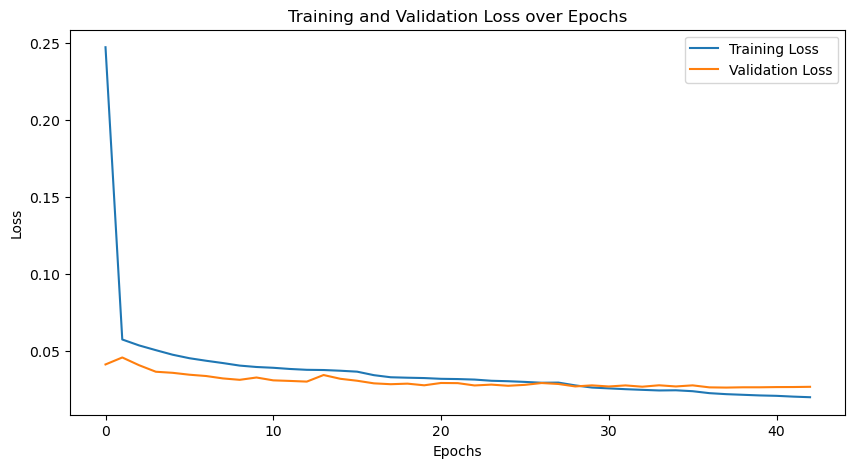

Finished Training


In [16]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

print('Finished Training')

## Evaluación y y Generación de Predicciones en el Conjunto de Test

### Evaluación de las Predicciones
- **Modo de Evaluación**: Se coloca el modelo en modo `eval()` para asegurar que las capas como dropout se comporten adecuadamente durante la evaluación.
- **Cálculo del F1 Score**: Se utiliza el mejor umbral determinado durante el entrenamiento para calcular el F1 Score en el conjunto de validación, proporcionando una medida de rendimiento del modelo.

### Preparación del Conjunto de Test
- **Clase `BirdSongTestDataset`**: Esta clase se encarga de cargar y procesar el conjunto de test. Funciona de manera similar a la clase usada para el conjunto de entrenamiento y validación, pero sin etiquetas, ya que se trata de datos no etiquetados para predicción.
- **DataLoader para Test**: Se crea un DataLoader específico para el conjunto de test, facilitando la iteración sobre los datos durante la predicción.

### Predicciones en el Conjunto de Test
- **Generación de Predicciones**: El modelo se aplica a cada segmento del conjunto de test, y las predicciones se almacenan en un diccionario.
- **Agregación de Predicciones**: Para cada archivo de audio, se agrega la predicción a nivel de segmento utilizando una operación lógica OR. Esto refleja la presencia de una clase de ave en cualquier segmento del audio.
- **Preparación para la Presentación**: Las predicciones se convierten en un DataFrame y se formatean para cumplir con los requisitos de presentación (p. ej., para una competición de Kaggle).
- **Guardado de Predicciones**: Finalmente, se guardan las predicciones en un archivo CSV para su posterior uso o presentación.

### Proceso de Predicción Detallado
1. **Evaluación del Modelo**: Se pone el modelo en modo de evaluación para garantizar la consistencia de las predicciones.
2. **Iteración sobre el DataLoader de Test**: Se procesan los datos del conjunto de test en lotes.
3. **Aplicación del Modelo y Umbral**: Se generan las predicciones usando el modelo y se aplican los umbrales para obtener predicciones binarias.
4. **Agregación de Segmentos de Audio**: Las predicciones de los segmentos individuales se combinan para formar una predicción única por archivo de audio.
5. **Conversión y Guardado de Resultados**: Las predicciones se formatean adecuadamente y se guardan en un archivo CSV.

In [17]:
print(f"Best threshold: {best_threshold_val}")

Best threshold: 0.4


In [18]:
model.eval()
audio_preds = defaultdict(list)
audio_labels = defaultdict(list)

with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(valid_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = (outputs > best_threshold_val).float()

        # Fetch the filename for each segment
        for i, (input_, label, pred) in enumerate(zip(inputs, labels, preds)):
            # Compute the correct index in the dataset
            dataset_index = batch_idx * valid_loader.batch_size + i
            filename = valid_dataset.get_filename(dataset_index)
            audio_preds[filename].append(pred.cpu().numpy())
            # The label should be the same for all segments of the same audio, so we append it only once
            if filename not in audio_labels:
                audio_labels[filename] = label.cpu().numpy()

# Aggregating the segment-level predictions for each audio to generate a single prediction for the whole audio
for filename in audio_preds:
    # Here, we take the max prediction for each class across all segments as the audio-level prediction
    audio_preds[filename] = np.maximum.reduce(audio_preds[filename])

all_labels = list(audio_labels.values())
all_preds = list(audio_preds.values())

f1_macro = f1_score(all_labels, all_preds, average='samples', zero_division=1)
print(f"F1 Score (Samples): {f1_macro}")


F1 Score (Samples): 0.5238805970149253


In [19]:
class BirdSongTestDataset(Dataset):
    def __init__(self, df, audio_dir, transform=None):
        segments = []

        unique_filenames = df['filename'].unique()
        for unique_filename in unique_filenames:
            audio_path = os.path.join(audio_dir, unique_filename)
            waveform, sample_rate = torchaudio.load(audio_path)
            total_segments = int(math.ceil(waveform.shape[1] / sample_rate))

            for idx in range(total_segments):
                start_time, end_time = idx, idx + 1
                segments.append({
                    'filename': unique_filename,
                    'segment_idx': idx,
                    'start': start_time,
                    'end': end_time,
                })

        self.segments = pd.DataFrame(segments)
        self.audio_dir = audio_dir
        self.transform = transform

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        row = self.segments.iloc[idx]
        audio_path = os.path.join(self.audio_dir, row['filename'])
        waveform, sample_rate = torchaudio.load(audio_path)

        start_sample = int(row['start'] * sample_rate)
        end_sample = int(row['end'] * sample_rate)
        waveform = waveform[:, start_sample:end_sample]

        if waveform.shape[1] < sample_rate:
            num_padding = sample_rate - waveform.shape[1]
            waveform = torch.cat([waveform, torch.zeros(1, num_padding)], dim=1)

        if self.transform:
            waveform = self.transform(waveform)

        return waveform, row['filename'], row['segment_idx']


test_csv = pd.read_csv(f'{base_path}data/test.csv')

def collate_fn(batch):
    # Extracting tensors from the first item of the data point
    segments = [item[0][0] for item in batch]  # Accessing the tensor in the tuple

    # Extracting filenames
    filenames = [item[1] for item in batch]

    # Stacking tensors
    segments_tensor = torch.stack(segments, dim=0)

    return segments_tensor, filenames


test_dataset = BirdSongTestDataset(test_csv, f'{base_path}data/test/', transform=valid_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

### Visualización en Modo de Depuración
Si el modo de depuración (`DEBUG`) está activo, se visualiza un ejemplo del conjunto de test para verificar el procesamiento y las predicciones.

nips4b_test005.wav
torch.Size([1, 128, 226])
Processing original_spectrograms with shape torch.Size([1, 128, 226])


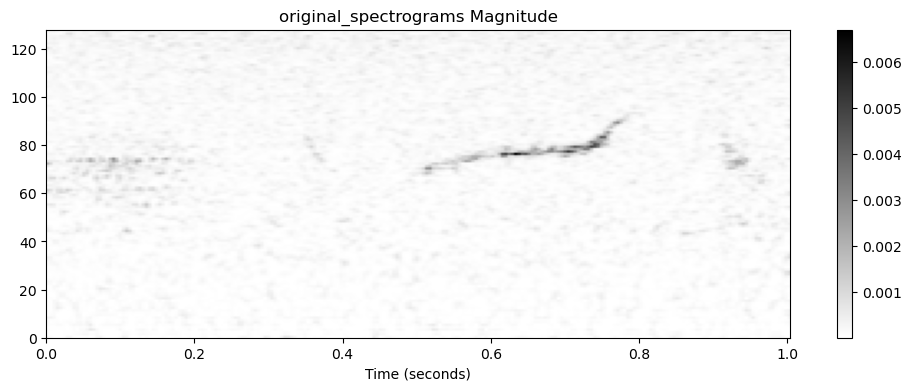

Processing spectrograms_after_median_blurring with shape torch.Size([1, 128, 226])


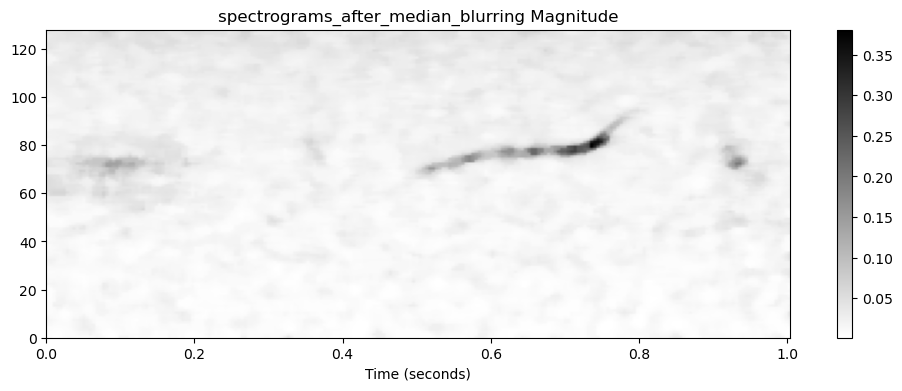

Processing binary_image with shape torch.Size([1, 128, 226])


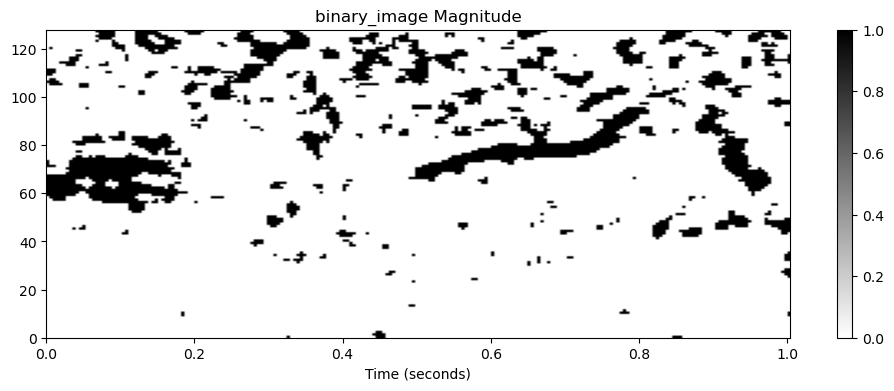

In [20]:
if DEBUG:
  (sample, intermediates), filename, label = test_dataset[25]
  print(filename)
  print(sample.shape)
  visualize_intermediates(intermediates)

In [21]:
# Make predictions on test set
model.eval()
predictions = defaultdict(lambda: np.zeros(len(class_names), dtype=bool))

with torch.no_grad():
    for inputs, filenames in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = (outputs > 0.1).float().cpu().numpy().astype(bool)

        for fname, pred in zip(filenames, preds):
            # Use logical OR to aggregate predictions for each audio. If the bird appears in one segment of the audio, it means that it appears in the whole audio.
            predictions[fname] = np.logical_or(predictions[fname], pred)

# Convert boolean values to integer (0 or 1)
for key in predictions:
    predictions[key] = predictions[key].astype(int)

submission_df = pd.DataFrame.from_dict(predictions, orient='index', columns=class_names)
submission_df.reset_index(inplace=True)
submission_df.rename(columns={'index': 'filename'}, inplace=True)
submission_df.to_csv('submission.csv', index=False)